In [1]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, ReLU, Lambda
tf.debugging.set_log_device_placement(False)

#from fl_mnist_implementation_tutorial_utils import *

# To splite the data between 3 clients

In [2]:
class DataGenerator2D(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """

    def __init__(self, base_path, img_size=256, batch_size=1, shuffle=True):

        self.base_path = base_path
        self.img_size = img_size
        self.id = os.listdir(os.path.join(base_path, "gt_image"))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.ceil(len(self.id) / float(self.batch_size)))

    def __load__(self, id_name):
        image_path = os.path.join(self.base_path, "gt_image", (id_name ))
        label_path = os.path.join(self.base_path, "gt_binary_image", (id_name ))
        #print(image_path)
        image = cv2.imread(image_path, 1)  # Reading Image in RGB format
        image = cv2.resize(image, (self.img_size, self.img_size))
        # image = cv2.resize(image, (int(img.shape[1]/2), int(img.shape[0]/2)))
        #print(label_path)
        mask = cv2.imread(label_path, 1)
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        # mask = cv2.resize(mask, (int(img.shape[1]/2), int(img.shape[0]/2)))

        # Normalizing the image
        image = image / 255.0
        mask = mask / 255.0

        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.id):
            file_batch = self.id[index * self.batch_size:]
        else:
            file_batch = self.id[index * self.batch_size:(index + 1) * self.batch_size]

        images, masks = [], []

        for id_name in file_batch:
            _img, _mask = self.__load__(id_name)
            images.append(_img)
            masks.append(_mask)

        images = np.array(images)
        masks = np.array(masks)
        #masks = masks.reshape((masks.shape[0], self.img_size, self.img_size,1))
        return images, masks

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


# Part 2 - Model

In [3]:

def simple_unet_model(IMG_HEIGHT=256, IMG_WIDTH =256, IMG_CHANNELS = 3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255.0)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path bin
    u6_bin = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6_bin = concatenate([u6_bin, c4])
    c6_bin = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6_bin)
    c6_bin = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6_bin)
     
    u7_bin = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6_bin)
    u7_bin = concatenate([u7_bin, c3])
    c7_bin = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7_bin)
    c7_bin = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7_bin)
     
    u8_bin = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7_bin)
    u8_bin = concatenate([u8_bin, c2])
    c8_bin = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8_bin)
    c8_bin = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8_bin)
     
    u9_bin = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8_bin)
    u9_bin = concatenate([u9_bin, c1], axis=3)
    c9_bin = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9_bin)
    c9_bin = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9_bin)
     
    bin_seg = Conv2D(1, (1, 1), activation='sigmoid', name='bin_seg')(c9_bin)
    
   
     
    model = Model(inputs=[inputs], outputs=[bin_seg])
    
    return model



# Evaluation Metrics


In [4]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + 1) / (union + 1), axis=0)
        
        return iou

    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice
    

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


# scalling

In [5]:
def weight_scalling_factor(clients_trn_data):
    #get the bs
    bs = 35
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data).numpy()*bs
    return local_count/3626


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = dice_coef_loss(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [7]:
#initialize global model
global_model = simple_unet_model()
comms_round = 100
opt = tf.keras.optimizers.Adam(1e-3)
metrics = [f1, iou , dice_coef ]
global_model.compile(loss=dice_coef_loss,
                      optimizer=opt,
                      metrics=metrics)
global_model.summary()
global_mat = []
client_1 = DataGenerator2D("E:/NU/TUsimple/train_set/training/clients/client_1/", img_size=256, batch_size=8, shuffle=True)
client_2 = DataGenerator2D("E:/NU/TUsimple/train_set/training/clients/client_2/", img_size=256, batch_size=8, shuffle=True)
client_3 = DataGenerator2D("E:/NU/TUsimple/train_set/training/clients/client_3/", img_size=256, batch_size=8, shuffle=True)
test = DataGenerator2D("E:/NU/TUsimple/test_set/teest", img_size=256, batch_size=35, shuffle=True)
clients = [client_1,client_2,client_3]



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  2320        ['conv2d_18[0][0]']              
                                )                                                           

 bin_seg (Conv2D)               (None, 256, 256, 1)  17          ['conv2d_35[0][0]']              
                                                                                                  
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________


In [8]:
lr = 1e-3
counter = 0
best_performance = float('inf')
#commence global training loop
for comm_round in range(comms_round):
    print("---------------------------------------------------------------------------------------")
    print("Epoch ", comm_round )
    print("---------------------------------------------------------------------------------------")
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #loop through each client and create new local model
    for client in clients:
        local_model = simple_unet_model() 
        opt = tf.keras.optimizers.Adam(lr)
        metrics = [f1, iou , dice_coef ]

        local_model.compile(loss=dice_coef_loss,
                      optimizer=opt,
                      metrics=metrics)
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(client, epochs=1 ,verbose=1,steps_per_epoch=30)
        
        #scale the model weights and add to list
        scaling_factor = 1/3
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    print("Performance Matrix ")
    #process and batch the test set 
    global_performance = global_model.evaluate(
                                    test,
                                    batch_size= 60, 
                                    verbose=1,
                                    )
    if(best_performance<=global_performance[0]):
        counter = counter + 1
    else:
        global_model.save_weights("E:/NU/TUsimple/train_set/training/clients/UNet/GlobalWeights.h5")
        print("Model loss imporved from", best_performance, "to",global_performance[0] )
        print("Model Saved in E:/NU/TUsimple/train_set/training/clients/UNet/GlobalWeights.h5" )
        best_performance = global_performance[0]
        counter = 0
    
    if(counter == 5):
        print("loss didn't imporve, so LR reduced from", lr, "to",lr*0.5 )
        lr=lr*0.5
        counter = 0
        
    global_mat.append(global_performance)
    print("---------------------------------------------------------------------------------------")


---------------------------------------------------------------------------------------
Epoch  0
---------------------------------------------------------------------------------------
30/30 [==============================] - 7s 199ms/step - loss: 0.8892 - f1: 0.1084 - iou: 0.0587 - dice_coef: 0.1108
Performance Matrix 
15/15 [==============================] - 13s 667ms/step - loss: 0.8795 - f1: 0.2256 - iou: 0.0642 - dice_coef: 0.1205
Model loss imporved from inf to 0.879541277885437
Model Saved in E:/NU/TUsimple/train_set/training/clients/UNet/GlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  1
---------------------------------------------------------------------------------------
30/30 [==============================] - 7s 188ms/step - loss: 0.8140 - f1: 0.1956 - iou: 0.1080 - dice_coef: 0.1860
Performance Matrix 
15/15 [==============

30/30 [==============================] - 7s 200ms/step - loss: 0.1773 - f1: 0.8259 - iou: 0.7234 - dice_coef: 0.8227
Performance Matrix 
15/15 [==============================] - 10s 643ms/step - loss: 0.1649 - f1: 0.8391 - iou: 0.7421 - dice_coef: 0.8360
Model loss imporved from 0.17047418653964996 to 0.16487061977386475
Model Saved in E:/NU/TUsimple/train_set/training/clients/UNet/GlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  10
---------------------------------------------------------------------------------------
30/30 [==============================] - 7s 197ms/step - loss: 0.2090 - f1: 0.7959 - iou: 0.6796 - dice_coef: 0.7910
Performance Matrix 
15/15 [==============================] - 10s 624ms/step - loss: 0.1439 - f1: 0.8587 - iou: 0.7736 - dice_coef: 0.8561
Model loss imporved from 0.16487061977386475 to 0.1439235508441925
Mo

30/30 [==============================] - 9s 265ms/step - loss: 0.0877 - f1: 0.9131 - iou: 0.8700 - dice_coef: 0.9123
Performance Matrix 
15/15 [==============================] - 10s 625ms/step - loss: 0.0654 - f1: 0.9351 - iou: 0.9019 - dice_coef: 0.9338
Model loss imporved from 0.0746581181883812 to 0.0654221847653389
Model Saved in E:/NU/TUsimple/train_set/training/clients/UNet/GlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  29
---------------------------------------------------------------------------------------
30/30 [==============================] - 8s 247ms/step - loss: 0.0590 - f1: 0.9431 - iou: 0.9211 - dice_coef: 0.9410
Performance Matrix 
15/15 [==============================] - 10s 624ms/step - loss: 0.0596 - f1: 0.9406 - iou: 0.9124 - dice_coef: 0.9397
Model loss imporved from 0.0654221847653389 to 0.05961734429001808
Mode

30/30 [==============================] - 7s 199ms/step - loss: 0.0729 - f1: 0.9264 - iou: 0.8901 - dice_coef: 0.9271
Performance Matrix 
15/15 [==============================] - 10s 614ms/step - loss: 0.0503 - f1: 0.9509 - iou: 0.9283 - dice_coef: 0.9495
Model loss imporved from 0.05260413512587547 to 0.05034780874848366
Model Saved in E:/NU/TUsimple/train_set/training/clients/UNet/GlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  39
---------------------------------------------------------------------------------------
30/30 [==============================] - 7s 194ms/step - loss: 0.0708 - f1: 0.9284 - iou: 0.8946 - dice_coef: 0.9292
Performance Matrix 
15/15 [==============================] - 10s 612ms/step - loss: 0.0544 - f1: 0.9465 - iou: 0.9240 - dice_coef: 0.9455
---------------------------------------------------------------------

30/30 [==============================] - 7s 194ms/step - loss: 0.0234 - f1: 0.9769 - iou: 0.9845 - dice_coef: 0.9766
Performance Matrix 
15/15 [==============================] - 10s 611ms/step - loss: 0.0384 - f1: 0.9629 - iou: 0.9491 - dice_coef: 0.9614
Model loss imporved from 0.04089973866939545 to 0.038382623344659805
Model Saved in E:/NU/TUsimple/train_set/training/clients/UNet/GlobalWeights.h5
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  49
---------------------------------------------------------------------------------------
30/30 [==============================] - 7s 206ms/step - loss: 0.0371 - f1: 0.9624 - iou: 0.9542 - dice_coef: 0.9629
Performance Matrix 
15/15 [==============================] - 10s 641ms/step - loss: 0.0389 - f1: 0.9632 - iou: 0.9511 - dice_coef: 0.9614
--------------------------------------------------------------------

30/30 [==============================] - 8s 218ms/step - loss: 0.0163 - f1: 0.9847 - iou: 1.0000 - dice_coef: 0.9837
Performance Matrix 
15/15 [==============================] - 10s 611ms/step - loss: 0.0339 - f1: 0.9677 - iou: 0.9618 - dice_coef: 0.9658
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  59
---------------------------------------------------------------------------------------
30/30 [==============================] - 7s 207ms/step - loss: 0.0248 - f1: 0.9758 - iou: 0.9798 - dice_coef: 0.9752
Performance Matrix 
15/15 [==============================] - 10s 622ms/step - loss: 0.0378 - f1: 0.9645 - iou: 0.9560 - dice_coef: 0.9625
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  60
------------------------------

30/30 [==============================] - 7s 193ms/step - loss: -0.0158 - f1: 1.0148 - iou: 1.0663 - dice_coef: 1.0158
Performance Matrix 
15/15 [==============================] - 9s 611ms/step - loss: 0.0240 - f1: 0.9782 - iou: 0.9837 - dice_coef: 0.9762
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  79
---------------------------------------------------------------------------------------
30/30 [==============================] - 7s 197ms/step - loss: -0.0201 - f1: 1.0203 - iou: 1.0727 - dice_coef: 1.0201
Performance Matrix 
15/15 [==============================] - 9s 607ms/step - loss: 0.0221 - f1: 0.9798 - iou: 0.9874 - dice_coef: 0.9779
loss didn't imporve, so LR reduced from 0.000125 to 6.25e-05
---------------------------------------------------------------------------------------
-------------------------------------------------------------------

30/30 [==============================] - 7s 197ms/step - loss: -0.0367 - f1: 1.0371 - iou: 1.1083 - dice_coef: 1.0367
Performance Matrix 
15/15 [==============================] - 10s 614ms/step - loss: 0.0226 - f1: 0.9797 - iou: 0.9877 - dice_coef: 0.9775
loss didn't imporve, so LR reduced from 3.125e-05 to 1.5625e-05
---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------
Epoch  90
---------------------------------------------------------------------------------------
30/30 [==============================] - 7s 195ms/step - loss: -0.0365 - f1: 1.0366 - iou: 1.1065 - dice_coef: 1.0365
Performance Matrix 
15/15 [==============================] - 10s 617ms/step - loss: 0.0223 - f1: 0.9799 - iou: 0.9879 - dice_coef: 0.9778
---------------------------------------------------------------------------------------
--------------------------------------------------------------

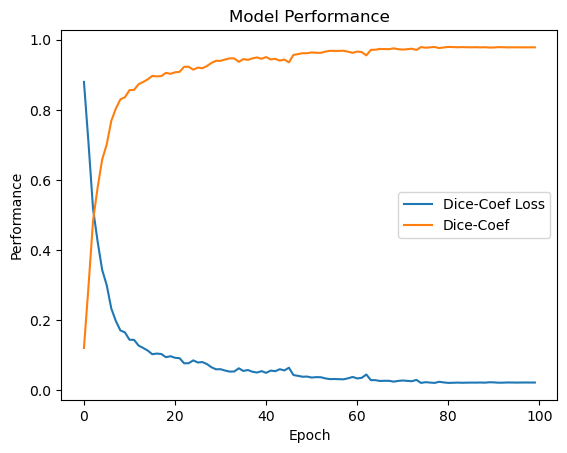

In [9]:

performance_matrix = list(map(list, zip(*global_mat)))
plt.plot(performance_matrix[0])
plt.plot(performance_matrix[3])
plt.title('Model Performance')
plt.ylabel('Performance')
plt.xlabel('Epoch')
plt.legend(['Dice-Coef Loss', 'Dice-Coef'])
plt.show()

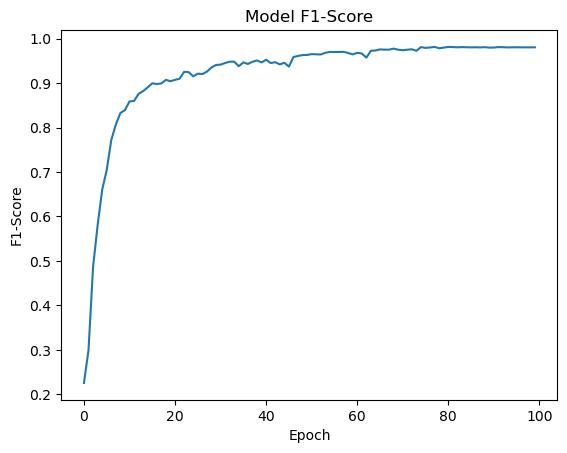

In [11]:
plt.plot(performance_matrix[1])
plt.title('Model F1-Score')
plt.ylabel('F1-Score')
plt.xlabel('Epoch')
plt.show()

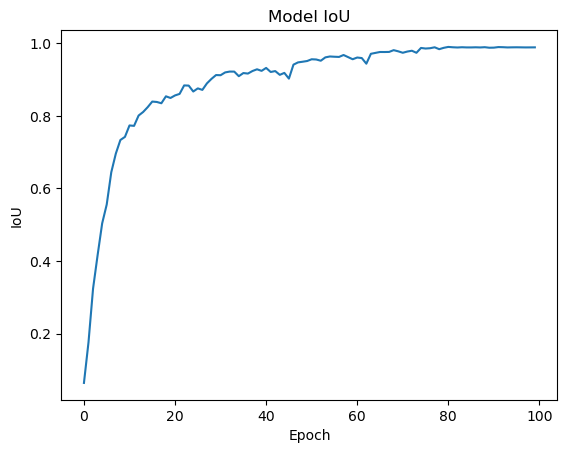

In [12]:
plt.plot(performance_matrix[2])
plt.title('Model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.show()

In [1]:
val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\teest", img_size=256,batch_size=128, shuffle=True)
global_model = simple_unet_model()
global_model.load_weights('E:/NU/TUsimple/train_set/training/clients/UNet/GlobalWeights.h5')
global_model.compile(loss=dice_coef_loss,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=[f1, iou , dice_coef ])
evaluate = global_model.evaluate(val_generator,batch_size= 60, verbose=1,)

NameError: name 'DataGenerator2D' is not defined

In [6]:
val_generator = DataGenerator2D(r"E:\NU\TUsimple\test_set\testing", img_size=256,batch_size=128, shuffle=False)
global_model = simple_unet_model()
global_model.load_weights('E:/NU/TUsimple/train_set/training/clients/UNet/GlobalWeights.h5')
X, y = val_generator.__getitem__(0)
predict = global_model.predict(X)


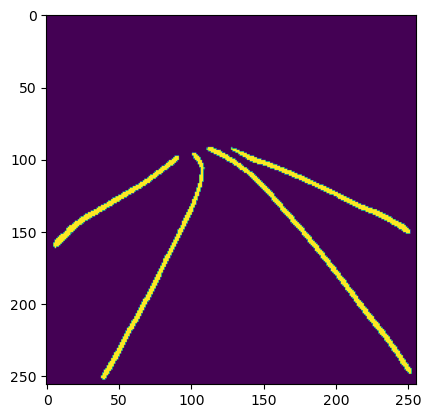

In [9]:
img = predict[5]
plt.imshow(img)

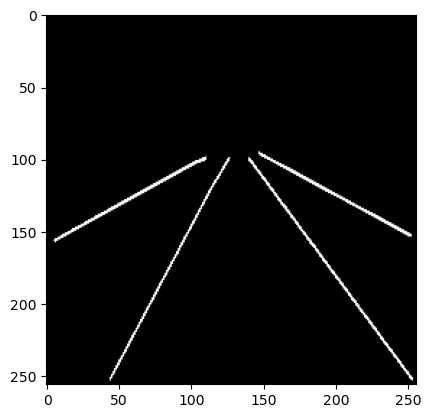

In [7]:
img1 = y[5]
plt.imshow(img1)

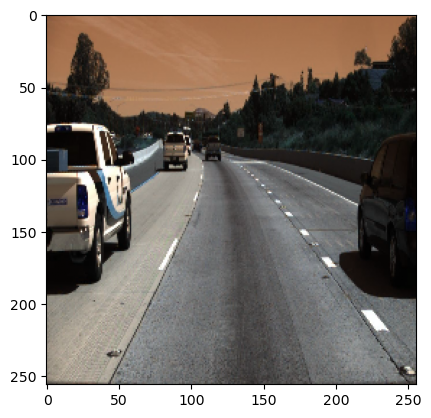

In [8]:
img = X[5]
plt.imshow(img)